# AMC Audience Insights Module 2.0 Template

This analysis helps generate audience insights based on AMC segment data.

## TOC:
* [Step 1: Import Packages](#first-bullet)
* [Step 2: Segment Data -  import, exploration and cleaning](#second-bullet)
* [Step 3: Natural Language Processing](#third-bullet)
* [Step 4: K-means clustering ](#fourth-bullet)
* [Step 5: Assign clusters to the original data](#fifth-bullet)

### Step 1 : Import packages <a class="anchor" id="first-bullet"></a>

In [ ]:
!pip install wordcloud

In [ ]:
!pip install umap-learn

In [ ]:
!pip install umap-learn[plot]

In [ ]:
!pip install plotnine

In [ ]:
!pip install pycopy-colorsys

In [ ]:
# This ammpy package is only needed if the query can be fnished within 2 hours and 
# users intend to extract AMC data directly within this notebook
!pip install --upgrade git+https://git-codecommit.us-east-1.amazonaws.com/v1/repos/ammpy

In [44]:
# import useful packages for data analysis, NLP processing and K-means 

# Data Structures
import numpy  as np
import pandas as pd
import glob

# Corpus Processing
import re
import nltk.corpus
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize
from sklearn.feature_extraction       import text
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.decomposition            import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# K-Means
from sklearn import cluster
from sklearn.cluster import KMeans

# UMAP
import umap
import umap.plot

# DBSCAN
from sklearn.cluster import DBSCAN

# Kmeans
from sklearn.cluster import KMeans

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from plotnine import *
from mizani.formatters import percent_format
from sklearn.metrics                  import silhouette_samples, silhouette_score
from wordcloud                        import WordCloud


from datetime import datetime
from datetime import date

# SQL automation
from jinja2 import Template


### AMC automation related packages
import requests_aws_sign
import requests
from aws_requests_auth.aws_auth import AWSRequestsAuth
import re
from ammpy import amc


%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    
    
    #############################################
## Import Viz packages
#############################################
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.ticker as mtick
import matplotlib.colors

font_manager._rebuild() ## loads Amazon custom fonts to python


#############################################
## Define default colour palette and font
#############################################

## Define colour palette (Orange, grey only)
colors = [
        "#FF5A00", #Cascade orange
        "#3E4143", #Darkest gray
        "#808285", #Light gray
        '#B3B4B6', #Lighter gray
        
        ]

## Define colour palette (full range)
colors_full = [
        "#FF5A00", #Cascade orange
        "#009596", #Niagara green
        "#3446C5", #Royal blue
        "#00A1E5", #Seattle sky blue
        "#BB2CAC", #Grape purple
        "#FF71B5", #Rose pink
        "#232F3F", #Squid ink
        "#808285", #Light gray
        ]


cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors) # cmap using colors
cmap2 =\
matplotlib.colors.LinearSegmentedColormap.from_list("", colors_full) # cmap2 using colors_full


## Define default font
default_font = "Amazon Ember Display" # Set default font family to Amazon Ember Display
squid_ink_colour = "#232F3F" #Squid ink
light_grey_colour = "#808285" #Light gray




#############################################
## Apply global settings
#############################################

## Global settings
sns.set_style('white') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titleweight='bold')     # bold the title
plt.rcParams["font.family"] =  default_font # set default font family

plt.rcParams['text.color'] = squid_ink_colour #set default font colour for text as Squid Ink
plt.rcParams['axes.labelcolor'] = light_grey_colour # set default font colour for labels
plt.rcParams['xtick.color'] = light_grey_colour # set default font colour for x axis ticks
plt.rcParams['ytick.color'] = light_grey_colour # set default font colour for y axis ticks

# remove frame border, but keep bottom and left
plt.rcParams['axes.spines.left'] = True  
plt.rcParams['axes.spines.bottom'] = True  
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  


#############################################
## Apply configurable settings 
#############################################

####!!!!!!!!!!!!!! CHANGE BELOW VALUES DEPENDING ON YOUR USE CASE !!!!!!!!!!!!!!####

sns.set_palette(sns.color_palette(colors)) # Choose colors for orange/grey (useful for graphs with 1-3 colours)
#sns.set_palette(sns.color_palette(colors_full)) # Choose colors_full for full range (useful for graphs with 3+ colours)

plt.rcParams["figure.figsize"] = (10, 10) # define default size of graph
plt.rc('axes', titlesize=20)           # fontsize of title
plt.rc('axes', labelsize=15)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

### Step 2 : Import data, explore and clean <a class="anchor" id="second-bullet"></a>

In [45]:
# input parameters for SQL template
param_campaign = pd.read_excel('AMC Audience Insights Parameters.xls', sheet_name='campaign_id', index_col=None)
param_region = pd.read_excel('AMC Audience Insights Parameters.xls', sheet_name='region', index_col=None)

In [46]:
# user defined parameters
brand = 'Honda'
presenter = 'test1'

# set this paramerter to true if user wants location based analysis
# For every dma_code, there should be a matching region
region_flag = False

if region_flag:
    dma_code = param_region['dma_code']
    region = param_region['region']
    
    assert len(list(filter(None, dma_code))) == len(list(filter(None, region))), \
            'For every dma code,there should be a matching region'

    region_map = zip(dma_code,region)

In [47]:
# Main Query
if region_flag:
    sql_query_main = '''
    with purchases_last_total as (
    SELECT
    user_id
    ,max(event_dt_utc) as conversion_event_dt_last
    ,SUM(conversions) as purchases
    FROM
    conversions_unfiltered
    WHERE
    event_category = 'pixel'
    GROUP BY 1
    ),
    -----------------------------------------------
    -- Impression table for segments and geo at user id level.
    -- You can group DMA / states depending on how your advertiser does geo targeting/plan
    -- Recommendation is to create 5 or fewer groupings (e.g., Northeast, Midwest, Southea
    -----------------------------------------------
    impressions as (
    SELECT
    behavior_segment_id AS segment_id
    , behavior_segment_name AS segment_name
    , behavior_segment_matched AS segment_matched
    , dius.user_id
    , iso_state_province_code
    ,case
    {%- for dma_code, region in region_map %}
    when dma_code = '{{dma_code}}' THEN '{{region}}'
    {%- if not loop.last -%}

    {%- endif -%}
    {%- endfor %}
    END as region
    , min(impression_dt) as impression_dt_first
    , SUM(impressions) as impressions
    FROM
    display_impressions_by_user_segments dius -- LS, IM, LA, Demo
    WHERE
    impressions > 0
    AND campaign_id IN (

    {%- for campaign_id in campaign_id_list %}
     '{{campaign_id}}'
    {%- if not loop.last -%}
      ,
    {%- endif -%}
    {%- endfor %}



    )
    AND (
    -----------------------------------------------
    -- Due to the size of segment table, irrelevent or less insightful segments are filter
    -- Lifestyle (LS), In-Market (IM), Demographic (Demo), Lookalike (AL/LA) are included
    -----------------------------------------------
    behavior_segment_name similar to '^LS.*' OR
    behavior_segment_name similar to '^IM.*' OR
    -- behavior_segment_name similar to '^Demo - (?!Amazon).+' OR
    behavior_segment_name similar to '^Demo.*' OR
    behavior_segment_name similar to '^AL.*' OR
    behavior_segment_name similar to '^LA.*'
    )
    AND behavior_segment_id !=32
    GROUP BY 1,2,3,4,5,6
    ),
    -----------------------------------------------
    -- Combining purchases + impressions in one table with segment and geo
    -----------------------------------------------
    combined as (
    SELECT
    imp.segment_id
    , imp.segment_name
    , imp.segment_matched
    , imp.user_id AS imp_users
    , imp.impressions
    , imp.region
    , imp.iso_state_province_code
    , pur.purchases
    , pur.user_id AS pur_users
    , CASE
    -- WHEN conversion_event_dt_last IS NULL THEN 'no purchase
    WHEN conversion_event_dt_last IS NULL OR conversion_event_dt_last > impression_dt_first THEN 'pre-purchase'
    WHEN conversion_event_dt_last < impression_dt_first THEN 'post-purchase'
    ELSE 'other'
    END AS impression_timing
    FROM
    impressions imp
    LEFT JOIN purchases_last_total pur -- "how many pur.user_id do not exist
    ON pur.user_id = imp.user_id
    )
    -----------------------------------------------
    -- Reducing table to segment and geo level
    -----------------------------------------------
    SELECT
    segment_id
    , segment_name
    , segment_matched
    , region
    , impression_timing
    , count(distinct imp_users) reach_user
    , count(distinct pur_users) purch_user
    , sum(impressions) impressions
    , sum(purchases) purchases
    FROM
    combined
    GROUP BY 1,2,3,4,5
    having reach_user > 100 or purch_user > 0
    ;
    '''
else:
     sql_query_main = '''
    with purchases_last_total as (
    SELECT
    user_id
    ,max(event_dt_utc) as conversion_event_dt_last
    ,SUM(conversions) as purchases
    FROM
    conversions_unfiltered
    WHERE
    event_category = 'pixel'
    GROUP BY 1
    ),
    -----------------------------------------------
    -- Impression table for segments and geo at user id level.
    -- You can group DMA / states depending on how your advertiser does geo targeting/plan
    -- Recommendation is to create 5 or fewer groupings (e.g., Northeast, Midwest, Southea
    -----------------------------------------------
    impressions as (
    SELECT
    behavior_segment_id AS segment_id
    , behavior_segment_name AS segment_name
    , behavior_segment_matched AS segment_matched
    , dius.user_id
    , min(impression_dt) as impression_dt_first
    , SUM(impressions) as impressions
    FROM
    display_impressions_by_user_segments dius -- LS, IM, LA, Demo
    WHERE
    impressions > 0
    AND campaign_id IN (

    {%- for campaign_id in campaign_id_list %}
     '{{campaign_id}}'
    {%- if not loop.last -%}
      ,
    {%- endif -%}
    {%- endfor %}



    )
    AND (
    -----------------------------------------------
    -- Due to the size of segment table, irrelevent or less insightful segments are filter
    -- Lifestyle (LS), In-Market (IM), Demographic (Demo), Lookalike (AL/LA) are included
    -----------------------------------------------
    behavior_segment_name similar to '^LS.*' OR
    behavior_segment_name similar to '^IM.*' OR
    -- behavior_segment_name similar to '^Demo - (?!Amazon).+' OR
    behavior_segment_name similar to '^Demo.*' OR
    behavior_segment_name similar to '^AL.*' OR
    behavior_segment_name similar to '^LA.*'
    )
    AND behavior_segment_id !=32
    GROUP BY 1,2,3,4
    ),
    -----------------------------------------------
    -- Combining purchases + impressions in one table with segment and geo
    -----------------------------------------------
    combined as (
    SELECT
    imp.segment_id
    , imp.segment_name
    , imp.segment_matched
    , imp.user_id AS imp_users
    , imp.impressions
    , pur.purchases
    , pur.user_id AS pur_users
    , CASE
    -- WHEN conversion_event_dt_last IS NULL THEN 'no purchase
    WHEN conversion_event_dt_last IS NULL OR conversion_event_dt_last > impression_dt_first THEN 'pre-purchase'
    WHEN conversion_event_dt_last < impression_dt_first THEN 'post-purchase'
    ELSE 'other'
    END AS impression_timing
    FROM
    impressions imp
    LEFT JOIN purchases_last_total pur -- "how many pur.user_id do not exist
    ON pur.user_id = imp.user_id
    )
    -----------------------------------------------
    -- Reducing table to segment and geo level
    -----------------------------------------------
    SELECT
    segment_id
    , segment_name
    , segment_matched
    , impression_timing
    , count(distinct imp_users) reach_user
    , count(distinct pur_users) purch_user
    , sum(impressions) impressions
    , sum(purchases) purchases
    FROM
    combined
    GROUP BY 1,2,3,4
    having reach_user > 100 or purch_user > 0
    ;
    '''

In [48]:
# generating AMC compatible sql query
if region_flag:
    out_main = Template(sql_query_main).render(campaign_id_list = param_campaign['campaign_id'].tolist(),\
                                     region_map = region_map)
else:
    out_main = Template(sql_query_main).render(campaign_id_list = param_campaign['campaign_id'].tolist())

In [49]:
# save the sql file in the local directory
text_file = open("AMC Audience Insights Main.sql", "w")
_ = text_file.write(out_main)
text_file.close()

#### Extracting Data Directly from AMC

Note: if the query is expected to run more than 2 hours, we recommend to use the "offline" version which takes 
      AMC Audience Insights Main.sql file generated in the previous step and run directly on AMC instance.
      Load the result (.csv file) back to this module for further processing. See section "Offline Version: Reading    
      input data from .csv file from AMC".

In [ ]:
# setting up AMC parameters
# IMPORTANT: Replace the example instanceURL with the correct one found in your AMC instance 
instanceURL = 'https://42pugoh5e9.execute-api.us-east-1.amazonaws.com/prod' 

# change the workflow name by users 
workflow_name_ = 'linykev_amc_workflow' 

time_now = str(datetime.now())
time_now = re.sub(r"[^\w\s]", '', time_now)
time_now = re.sub(r"\s+", '_', time_now)
workflow_name = workflow_name_ + str(time_now)
print(workflow_name)

# IMPORTANT: the file name needs to match the sql file name produced by the sql template above
sql_query_file_name = 'AMC Audience Insights Main.sql'
f = open(f"{sql_query_file_name}", "r")
sqlQuery1 = f.read()

#America/New_York Timezone
# IMPORTANT: users should change the start date, end date and timezone information
# full date range for Honda: 2/10-4/18
timeWindowStart = '2022-03-01T00:00:00'
timeWindowEnd =  '2022-03-04T00:00:00'
timeWindowTimeZone = 'America/New_York'

inputDict1 = {'workflow_name': workflow_name,
             'sqlQuery':sqlQuery1, 
             'timeWindowStart':timeWindowStart, 
             'timeWindowEnd':timeWindowEnd,
              'timeWindowTimeZone': timeWindowTimeZone,
             'instanceURL': instanceURL}

#### AMC Paramter Setting (continued)

aws_region: choose the region which is most appropriate for your locale

In [ ]:
# testing connection
aws_host = re.sub("https://|/prod", '', instanceURL)
aws_region = 'us-east-1'
auth = amc.connect_to_cluster(aws_host,aws_region)

In [ ]:
# trigger query
workflowExecutionId = amc.trigger_amc_query(inputDict1,auth)

In [ ]:
# checking workflow status. If it is "SUCCEED", we can continue; if not, please proceed to below "offline version"
status = amc.check_workflow_execution_status_async(inputDict1, workflowExecutionId, auth)
print(status)

In [ ]:
data = amc.fetch_output(status, workflowExecutionId, inputDict1, auth)

#### Offline Version: Reading input data from .csv file from AMC

In [50]:
# reading input data directly from the output file produced by AMC
data = pd.read_csv('AMC Audience Test2.csv')

#### Data Processing Starts Below 

In [51]:
data.head()

,segment_id,segment_name,segment_matched,impression_timing,reach_user,purch_user,impressions,purchases
0,478.0,IM - Computer Components,0,post-purchase,20,20,43,89.0
1,481.0,IM - Nintendo DS,0,post-purchase,3,3,4,5.0
2,3297.0,LS - Luxury Car Owners,0,post-purchase,26,26,39,145.0
3,4492.0,LS - Midsize Sedan Owners,0,post-purchase,30,30,49,150.0
4,5842.0,IMDb Custom Segment Request - A24-Rover,0,pre-purchase,2849,28,5103,145.0


In [52]:
# we only care about pre-purchase event. It is defined as 
# conversion_event_dt_last IS NULL OR conversion_event_dt_last > impression_dt_first THEN 'pre-purchase'
pre_df = data[data['impression_timing']=='pre-purchase'].copy()

In [53]:
pre_df.shape

(9344, 8)

In [54]:
# filter NA
pre_df.dropna(inplace=True)

In [55]:
pre_df.shape

(8448, 8)

In [56]:
# conversion rate metrics
pre_df['cvr'] = pre_df['purchases']/pre_df['impressions']

### Step 3 : Natural Language Processing <a class="anchor" id="first-bullet"></a>

In [57]:
# pre-defined list and noise work list are where we can filter out unwanted words in our audience segments
# 'book','fiction'
pr_list = ['LS - ','IM - ', 'Demo - ', 'AL -','Lookalikes','Look-alike','Lookalike']
noise_list = ['asin', 'abc', 'seller', 'central', 'amazon',\
              'aiv', 'al', 'make', 'model', 'interested', 'income', 'cell', 'permission','reference',\
              'segment','frequent','behavioral','product','spender','platform','book','fiction',\
             'similar', 'control', 'use', 'fi', 'shopper']
pre_df['segment_name_clean']=pre_df['segment_name'].str.replace('|'.join(pr_list),'')
#pre_df['segment_name_clean'] = pre_df['segment_name_clean'].str.replace('|'.join(noise_list),'')

#### For location-based analysis (region_flag is True), uncomment and execute the following cell with your dma_code before proceeding 

In [58]:
#### Note for location based analysis, additional filtering based on region is required before proceeding
#### For each region, run all the cells below to generate locale specific clustering analysis
# pre_df = pre_df[pre_df['region']=='your region code']

In [59]:
pre_df.head()

,segment_id,segment_name,segment_matched,impression_timing,reach_user,purch_user,impressions,purchases,cvr,segment_name_clean
4,5842.0,IMDb Custom Segment Request - A24-Rover,0,pre-purchase,2849,28,5103,145.0,0.028415,IMDb Custom Segment Request - A24-Rover
7,7244.0,IM - Lacrosse Products,0,pre-purchase,26501,249,51127,1354.0,0.026483,Lacrosse Products
8,7389.0,LS - Fiat Owners,0,pre-purchase,40133,327,81322,1658.0,0.020388,Fiat Owners
9,8159.0,IM - Protein Powder Viewers,0,pre-purchase,46581,468,89954,2492.0,0.027703,Protein Powder Viewers
11,11639.0,IM - Facial Tissue,0,pre-purchase,1409,15,2526,97.0,0.038401,Facial Tissue


In [60]:
#Preparing data for vectorization. When doing natural language processing, 
# words must be converted into vectors that machine learning algorithms can make use of.
# Remove punctuation from segment names
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc).union(noise_list)
desc = pre_df['segment_name_clean'].values.astype('U')
vectorizer = TfidfVectorizer(stop_words = stop_words)

# vectorize audience segment
X = vectorizer.fit_transform(desc)

In [61]:
#test = ' '.join(desc.tolist())
#test.find('clubs')

In [62]:
word_features = vectorizer.get_feature_names()
print(len(word_features))
print(word_features[1000:1100])

4768
['constitutional', 'construction', 'consumables', 'consumed', 'consumer', 'consumers', 'consumerspend', 'contact', 'container', 'containers', 'contemporary', 'content', 'continuing', 'continuous', 'contract', 'controlled', 'controllers', 'controls', 'convection', 'convenience', 'conversation', 'conversion', 'converters', 'convertible', 'cook', 'cookbook', 'cookbooks', 'cookers', 'cookie', 'cookies', 'cooking', 'cooks', 'cooktops', 'cookware', 'coolers', 'cooling', 'cooper', 'copper', 'copy', 'coq10', 'cor', 'cord', 'cordless', 'cords', 'corks', 'corkscrews', 'corn', 'corner', 'cornhole', 'corolla', 'correction', 'correspondence', 'corrugated', 'corvette', 'cosmetic', 'cosmetics', 'cosmology', 'costume', 'costumes', 'cots', 'cotton', 'cough', 'counseling', 'counted', 'counter', 'countertop', 'country', 'coupe', 'couples', 'coupon', 'couscous', 'cover', 'coveralls', 'covergirl', 'coverlet', 'coverlets', 'covers', 'cowboy', 'cox', 'cozy', 'cpu', 'cr', 'cracker', 'crackers', 'cradles'

### Step 3.2 : Stemming <a class="anchor" id="third-bullet"></a>  

#### Tokenizing - breaking the sentence into words and punctuation

In [63]:
# tf–idf or TFIDF, short for term frequency–inverse document frequency, 
# is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.
import nltk
nltk.download('wordnet')

stemmer = SnowballStemmer('english')

tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def tokenize(text):
    return [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text.lower())]

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [64]:
vectorizer2 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize)
X2 = vectorizer2.fit_transform(desc)
word_features2 = vectorizer2.get_feature_names()
print(len(word_features2))
print(word_features2[:50]) 

3967
["'s", 'abrams', 'academia', 'academic', 'academy', 'acadia', 'accent', 'access', 'accessory', 'accord', 'account', 'accounting', 'acid', 'acne', 'acoustic', 'acoustical', 'acquired', 'acrylic', 'action', 'active', 'activewear', 'activist', 'activity', 'actor', 'acura', 'adam', 'adaptation', 'adapter', 'adaption', 'additive', 'address', 'adhesive', 'adjustable', 'administration', 'adopter', 'adult', 'advance', 'advent', 'adventure', 'advil', 'aerial', 'affair', 'affluent', 'aftermarket', 'aftershaves', 'age', 'aged', 'agency', 'agent', 'aging']


In [65]:
# Include max_feature parameters:consider only the top max_features ordered by term frequency across the corpus. 
vectorizer3 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 1000)
X3 = vectorizer3.fit_transform(desc)
words = vectorizer3.get_feature_names()
print(len(words))
print(words[:50]) 

1000
['accent', 'accessory', 'action', 'active', 'activewear', 'activity', 'acura', 'adapter', 'adhesive', 'adult', 'adventure', 'age', 'aid', 'air', 'album', 'alexa', 'alternative', 'american', 'amplifier', 'android', 'animal', 'animation', 'anime', 'anthology', 'antique', 'app', 'apparel', 'appliance', 'apps', 'aquarium', 'area', 'arm', 'art', 'artificial', 'artist', 'asian', 'assembly', 'asset', 'assortment', 'athletic', 'attachment', 'audi', 'audio', 'auto', 'automation', 'automotive', 'award', 'b', 'baby', 'backpack']


In [66]:
# Three dimensionality reduction methods are provided: PCA, UMAP and T-SNE. The default method is PCA.
def dimension_reduction(array, method="PCA"):
    if method == 'PCA':
        svd = TruncatedSVD(n_components=3, random_state=42)
        result = svd.fit_transform(array)
    elif method == 'UMAP':
        result = umap.UMAP(n_components=2, metric='hellinger').fit_transform(array)
    else:
        result = TSNE(n_components=2, verbose=1, random_state=123).fit_transform(array)
    
    return result

In [67]:
X_reduced = {}
method = ['PCA','UMAP','t-SNE']

for m in method:
    X_reduced[m]=dimension_reduction(X3, method=m) # try X2 instead of X3

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8448 samples in 0.001s...
[t-SNE] Computed neighbors for 8448 samples in 2.021s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8448
[t-SNE] Computed conditional probabilities for sample 2000 / 8448
[t-SNE] Computed conditional probabilities for sample 3000 / 8448
[t-SNE] Computed conditional probabilities for sample 4000 / 8448
[t-SNE] Computed conditional probabilities for sample 5000 / 8448
[t-SNE] Computed conditional probabilities for sample 6000 / 8448
[t-SNE] Computed conditional probabilities for sample 7000 / 8448
[t-SNE] Computed conditional probabilities for sample 8000 / 8448
[t-SNE] Computed conditional probabilities for sample 8448 / 8448
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.861313
[t-SNE] KL divergence after 1000 iterations: 1.849704


#### Recommendation

There are two clustering methods available in this module: Kmeans and DBSCAN. Due to the large size of input tf-idf, it is recommended that users should use one of the dimensionality reduction methods with Kmeans clustering. The most optimal number of clusters, k, could be detremined by inspecting the elbow plot and silhouette score ( range between 0 and 1, low score indicates cluster overlapping while high score indicates better better clustering quality). For DBSCAN, this method might not need the dimensionality reduction method on the input tf-idf matrix but DBSCAN could produce arbitrary number of clusters which might not be easy to interpret from business perspective. 

In [68]:
# Two clustering methods are avaialble: Kmeans and DBSCAN
def Kmeans_assessment(array, method='PCA'):
    # method parameter is used to keep track of the dimensionality reduction method used for the input data
    
    wcss = []
    silhouette_score_list = []
    fig = plt.figure(figsize=(8, 6))
    result={}
    
    for i in range(2,11):
        kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
        kmeans.fit(array)
        score = silhouette_score(array, kmeans.labels_, metric='euclidean')
        silhouette_score_list.append(score)
        wcss.append(kmeans.inertia_)
        
    plt.plot(range(2,11),wcss)
  
    plt.title('The Elbow Plot - Dimensionality Reduction Method: '+ method)
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
     
    # Save the elbow plot, method parameter and performance metrics to dictionary
    result['elbow_plot'] = fig
    result['method'] = method
    result['metrics'] = {'wcss':wcss,'silhouette_score':silhouette_score_list}
    
    return result

def DBSCAN_assessment(array):
    
    # Defining the list of hyperparameters to try
    eps_list=np.arange(start=0.1, stop=0.9, step=0.1)
    min_sample_list=np.arange(start=2, stop=5, step=1)
 
    # Creating empty data frame to store the silhouette scores for each trials
    silhouette_scores_data=pd.DataFrame()
 
    for eps_trial in eps_list:
        for min_sample_trial in min_sample_list:
        
        # Generating DBSAN clusters
            dbscan = DBSCAN(eps=eps_trial, min_samples=min_sample_trial)
        
            if(len(np.unique(dbscan.fit_predict(array)))> 1):
                sil_score=silhouette_score(array, dbscan.fit_predict(array))
            else:
                continue
        
            trial_parameters="eps:" + str(eps_trial.round(1)) +" min_sample :" + str(min_sample_trial)
            silhouette_scores_data= \
            silhouette_scores_data.append(pd.DataFrame(data=[[sil_score,trial_parameters]],\
                                                       columns=["score", "parameters"]))
    return silhouette_scores_data.sort_values(by='score', ascending=False).head(1)

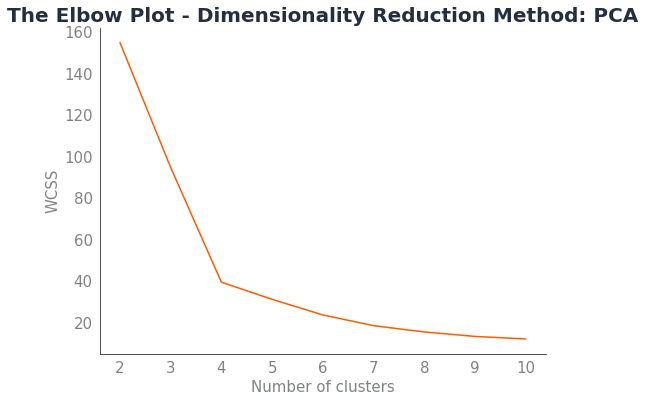

In [69]:
test = Kmeans_assessment(X_reduced['PCA'])

In [70]:
# This is what AMC Audience Insights 1.0 would look like
#test_orig = Kmeans_assessment(X3,'None')

In [71]:
test

{'elbow_plot': <Figure size 576x432 with 1 Axes>,
 'method': 'PCA',
 'metrics': {'wcss': [154.84933697489544,
   94.65124521032384,
   39.392777901956,
   31.11691796501925,
   23.608874819187477,
   18.43353573093381,
   15.407187183112773,
   13.271809923456239,
   12.031684833207342],
  'silhouette_score': [0.8645869316860725,
   0.8621360609839921,
   0.8597520111070038,
   0.8416956608631897,
   0.8451054671559056,
   0.8466272206660489,
   0.7213150633863326,
   0.7236239032523717,
   0.7118633947722836]}}

In [72]:
test_db = DBSCAN_assessment(X_reduced['PCA'])

In [73]:
test_db.head()

,score,parameters
0,0.845299,eps:0.2 min_sample :3


Note: DBSCAN has two hypoer-parameters: 

1. esp: The maximum distance between two samples for one to be considered as in the same cluster.
2. min_sample: The number of samples (or total weight) in a neighborhood (cluster) for a point to be considered as a core point. This includes the point itself

In [74]:
dbscan = DBSCAN(eps=0.2, min_samples=3)
db_pred = dbscan.fit_predict(X_reduced['PCA'])

### Step 4 : Clustering <a class="anchor" id="fourth-bullet"></a>

In [75]:
def generate_wordclouds(X, in_X_tfidf, in_word_positions,cmap=cmap,k=3 ,method = 'Kmeans',\
                        eps=0,min_samples=0,top_count=50 ,title=[]):

    # Clustering
    if method == 'Kmeans':
        kmeans = KMeans(n_clusters=k, random_state=42, n_jobs=-1)
        in_y_pred = kmeans.fit_predict(X)
        labels = kmeans.labels_
        pre_df['label'] = labels
    else:
        # DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        in_y_pred = dbscan.fit_predict(X)
        labels = dbscan.labels_
        pre_df['label'] = labels
        
    in_cluster_ids = set(in_y_pred)
    silhouette_avg = silhouette_score(X, in_y_pred)
 
    # Number of words with highest tfidf score to display
    top_count = top_count

    for in_cluster_id in in_cluster_ids:
        # compute the total tfidf for each term in the cluster
        in_tfidf = in_X_tfidf[in_y_pred == in_cluster_id]
        # numpy.matrix
        tfidf_sum = np.sum(in_tfidf, axis=0)
        # numpy.array of shape (1, X.shape[1])
        tfidf_sum = np.asarray(tfidf_sum).reshape(-1)
        top_indices = tfidf_sum.argsort()[-top_count:]
        term_weights = {in_word_positions[in_idx]: tfidf_sum[in_idx] for in_idx in top_indices}
        #wc = WordCloud(width=1200, height=800, background_color="white", color_func=my_color_func, random_state=23)
        wc = WordCloud(width=1200, height=800, background_color="white", colormap=cmap, random_state=23)
        wordcloud = wc.generate_from_frequencies(term_weights)
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")
        
        if len(title)== len(in_cluster_ids):
            #fig.suptitle(f"Cluster {in_cluster_id}")
            fig.suptitle(title[in_cluster_id])
        plt.show()

    return in_cluster_ids

def my_color_func(word=None, font_size=None, position=None,  orientation=None,\
                      font_path='Amazon Ember Display', random_state=None):
    h = 21
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(255.0 * 0.5) / 255.0)
    
    return "hsl({}, {}%, {}%)".format(h, s, l)

#### Recommendation

The title variable should consist of the main topic for each cluster and the main topics could not be identified until users have run the wordcloud function at least once. Our recommendation is that users should first run the wordcloud function with empty title list and identify the main topic for each cluster. Run the wordcloud function again with title variable filled with the selected main topics for reporting.

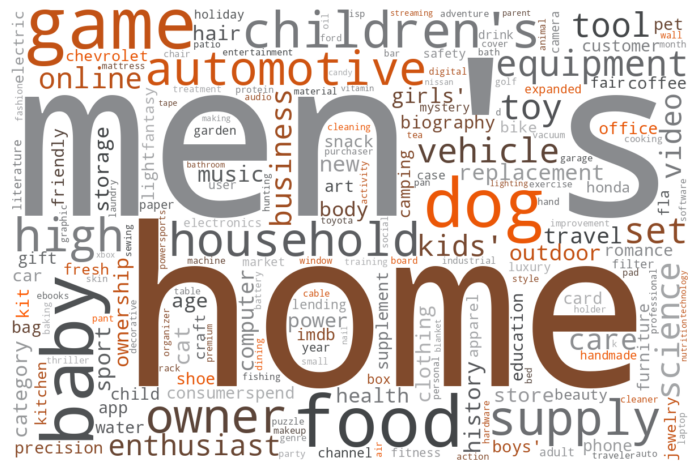

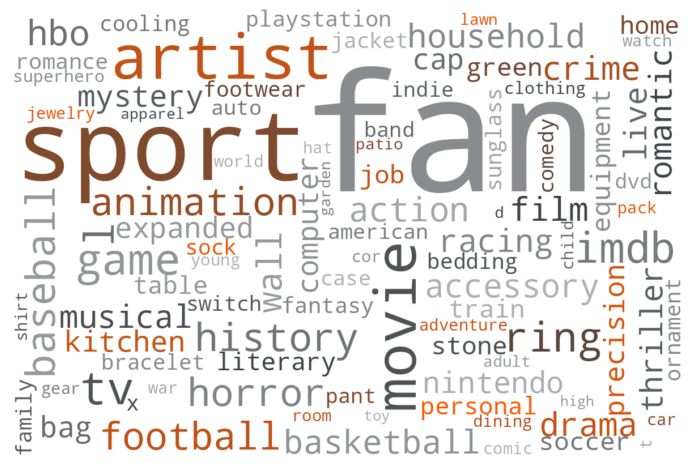

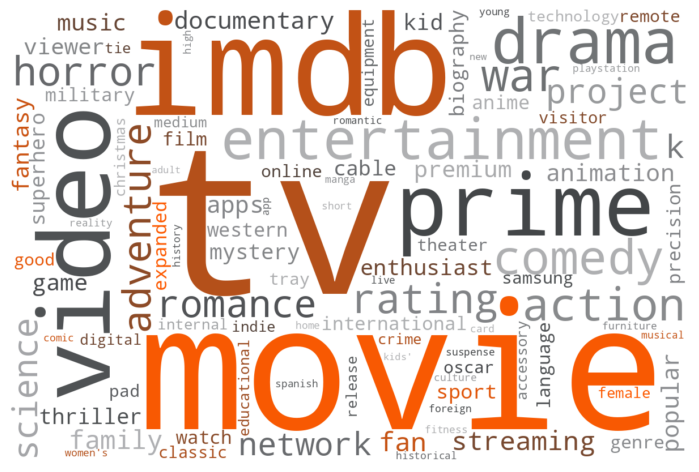

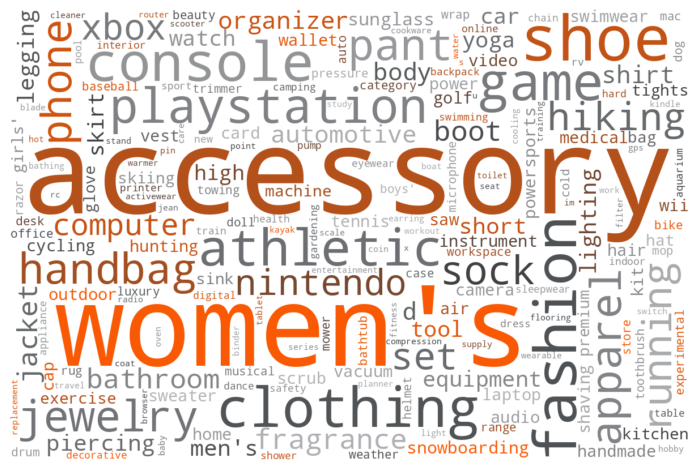

{0, 1, 2, 3}

In [76]:
# Note: Because we have to see the wordcloud first before making comments on the theme for eachh wordcloud, 
#       the title list almost surely needs to be empty list the first time we run the wordcloud function

optimal_k = 4 # obtained from elbow plot and silhouette_score

#### Uncomment 
#title= ['Books, Family and Household Supplies','Fashion','Interests and Hobbies','Streaming Content']
title = []

word_positions = {v: k for k, v in vectorizer3.vocabulary_.items()}
generate_wordclouds(X = X_reduced['PCA'],in_X_tfidf=X3,in_word_positions=word_positions,cmap=cmap, k=optimal_k,\
                    top_count=1000 ,title=title)

#### using DBSCAN-clustered wordcloud
#generate_wordclouds(X = X_reduced['PCA'],in_X_tfidf=X3,in_word_positions=word_positions,\
 #                   method='DBSCAN',eps=0.1, min_samples=3)

### Step 5 : Cluster Related Analytics  <a class="anchor" id="fifth-bullet"></a>  

In [77]:
# create description for each label
col = 'label'
conditions = [pre_df[col]==0, pre_df[col]==1, pre_df[col]==2, pre_df[col]==3]
choices = ['Family & Home','Interests & Hobbies','Movie & TV Streaming','Fashion & Personal Care']
pre_df['label_desc'] = np.select(conditions, choices)


In [78]:


pre_df_agg = \
pre_df.groupby('label_desc', as_index=False).agg({'purchases':sum,'impressions':sum,'reach_user':sum})

pre_df_agg['cvr'] = pre_df_agg['purchases'] / pre_df_agg['impressions']
pre_df_agg['frequency'] = pre_df_agg['impressions'] / pre_df_agg['reach_user']
pre_df_agg['reach_pct'] = pre_df_agg['reach_user'] / pre_df_agg['reach_user'].sum()

In [79]:
pre_df_agg['overall_avg_cvr'] = sum(pre_df_agg['purchases']) / sum(pre_df_agg['impressions'])
pre_df_agg['overall_avg_freq'] = sum(pre_df_agg['impressions']) / sum(pre_df_agg['reach_user'])

pre_df_agg['overall_total_reach'] = sum(pre_df_agg['reach_user'])

In [80]:
pre_df_agg

,label_desc,purchases,impressions,reach_user,cvr,frequency,reach_pct,overall_avg_cvr,overall_avg_freq,overall_total_reach
0,Family & Home,7631675.0,312150998,166621537,0.024449,1.873413,0.883005,0.02446,1.875752,188698360
1,Fashion & Personal Care,279416.0,11016039,5917628,0.025364,1.861563,0.031360,0.02446,1.875752,188698360
2,Interests & Hobbies,242400.0,9937319,5228033,0.024393,1.900776,0.027706,0.02446,1.875752,188698360
3,Movie & TV Streaming,504174.0,20847048,10931162,0.024184,1.907121,0.057929,0.02446,1.875752,188698360


In [81]:
# plotting conversion rate graph sorted by conversion rate
overall_avg_cvr = pre_df_agg['overall_avg_cvr'].values[0]
t=pre_df_agg['cvr'].max()

slide_conv_g = ggplot(pre_df_agg, aes(x="reorder(label_desc,cvr)", y="cvr")) + \
        geom_bar(aes(fill="cvr"), stat="identity") + \
        geom_hline(yintercept = overall_avg_cvr, color="grey", size=2) + \
        labs(x="Audience Cluster", y="Conversion Rate") + scale_y_continuous(labels=percent_format()) + \
        theme_minimal() + theme_bw() + theme(panel_grid = element_blank(),
        plot_background = element_blank(), 
        panel_grid_major = element_blank(),
        panel_grid_minor = element_blank(),
        panel_border = element_blank(),
        text = element_text(size=14), legend_position = "none") + coord_flip() + \
        scale_fill_gradient(low = "grey", high = "orangered")

  #annotate(geom="text", label="Average Conversion Rate", x=1, y=overall_avg_cvr, ha="right") + \
    # axis_text_x = element_text(angle = 90)

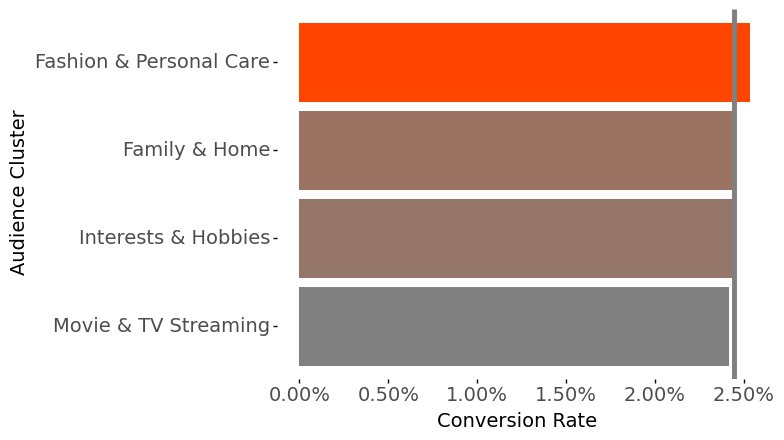

<ggplot: (-9223363292245348043)>

In [82]:
slide_conv_g

In [83]:
# plot reach graph
#overall_avg_freq = pre_df_agg['overall_avg_freq'].values[0]
t=pre_df_agg['reach_pct'].max()
slide_reach_g = ggplot(pre_df_agg, aes(x="reorder(label_desc,reach_pct)", y="reach_pct")) + \
          geom_bar(aes(fill="reach_pct"),stat = "identity") + \
          theme(axis_text_x = element_text(angle = 90)) + \
          labs(x="Audience Cluster", y="Percentage of Reach") + coord_flip() + \
          theme_minimal() + theme_bw() + theme(panel_grid = element_blank(),
          plot_background = element_blank(), panel_grid_major = element_blank(),
          panel_grid_minor = element_blank(),panel_border = element_blank(),
          text = element_text(size=14), legend_position = "none") + \
          scale_y_continuous(labels=percent_format()) + \
          scale_fill_gradient(low = "grey", high = "orangered")
         

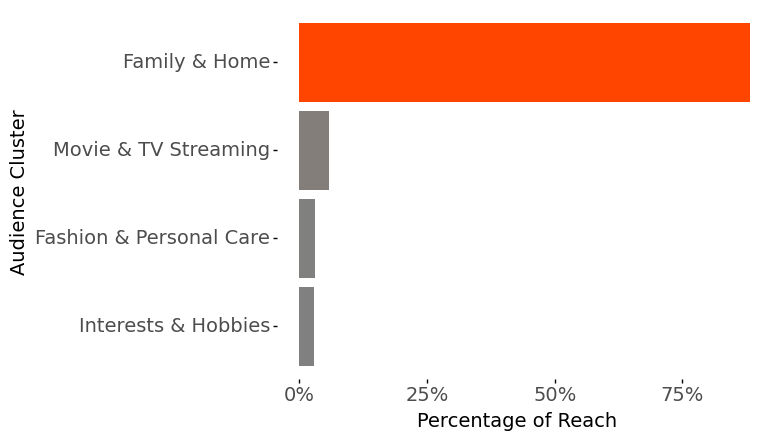

<ggplot: (-9223363292219193393)>

In [84]:
slide_reach_g

In [85]:
pre_df_agg

,label_desc,purchases,impressions,reach_user,cvr,frequency,reach_pct,overall_avg_cvr,overall_avg_freq,overall_total_reach
0,Family & Home,7631675.0,312150998,166621537,0.024449,1.873413,0.883005,0.02446,1.875752,188698360
1,Fashion & Personal Care,279416.0,11016039,5917628,0.025364,1.861563,0.031360,0.02446,1.875752,188698360
2,Interests & Hobbies,242400.0,9937319,5228033,0.024393,1.900776,0.027706,0.02446,1.875752,188698360
3,Movie & TV Streaming,504174.0,20847048,10931162,0.024184,1.907121,0.057929,0.02446,1.875752,188698360


In [86]:
# save graphs for pptx
slide_conv_g.save('slide_conv_g.png',width=12, height=6, dpi=200)
slide_reach_g.save('slide_reach_g.png',width=8, height=8, dpi=200)

In [87]:
pre_df_summary = pre_df.sort_values(by=['label_desc','cvr'], ascending=[True,False])

In [88]:
# write raw data to excel file
import pandas.io.formats.excel
pandas.io.formats.excel.ExcelFormatter.header_style = None

filedate = str(date.today()).replace('-','')

with pd.ExcelWriter('AMC_Audience_Insights_' + brand + '_' + presenter + '_' + filedate + '.xlsx') as writer:
    pre_df_agg.to_excel(writer, sheet_name = 'Audience Insights Aggregated', index=False)
    pre_df_summary.to_excel(writer, sheet_name='Audience Insights Summary', index=False)

In [89]:
pre_df_agg

,label_desc,purchases,impressions,reach_user,cvr,frequency,reach_pct,overall_avg_cvr,overall_avg_freq,overall_total_reach
0,Family & Home,7631675.0,312150998,166621537,0.024449,1.873413,0.883005,0.02446,1.875752,188698360
1,Fashion & Personal Care,279416.0,11016039,5917628,0.025364,1.861563,0.031360,0.02446,1.875752,188698360
2,Interests & Hobbies,242400.0,9937319,5228033,0.024393,1.900776,0.027706,0.02446,1.875752,188698360
3,Movie & TV Streaming,504174.0,20847048,10931162,0.024184,1.907121,0.057929,0.02446,1.875752,188698360


## References

#### Dimensionality Reduction

1. [Principal Component Analysis - Singular Value Decomposition](https://jonathan-hui.medium.com/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491)
2. [Uniform Manifold Approximation and Projection (UMAP)](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html)
3. [t-distributed stochastic neighbor embedding (t-SNE)](https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1)


#### Clustering

1. [Kmeans Clustering](https://www.learnbymarketing.com/methods/k-means-clustering/)
2. [DBSCAN](https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html)